# TRABAJO FINAL PROCESAMIENTO DEL LENGUAJE NATURAL 
ALUMNOS : 

- ALEJANDRO MADRID GALARZA
- ANTONIO JOSÉ LÓPEZ MARTÍNEZ


### MOTIVACIÓN DEL TRABAJO
Vamos a realizar una aplicacion 'python' en 'jupyter-lab' para la asignatura de Procesamiento del Lenguaje Natural en la que trataremos, con los conocimientos adquiridos en la asignatura así como todo lo que sea necesario para la resolución del mismo, una aplicación que clasifique un conjunto de más de 3500 'tweets' en un clasificador de 11 clases que corresponden a 11 emociones distintas sobre las que clasificaremos.

##### IMPORTS

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
import unidecode
#
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
#
from spacy.lang.es.stop_words import STOP_WORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
#
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Dropout, Conv1D, MaxPooling1D, SpatialDropout1D, TimeDistributed, Flatten, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
#


### Cargamos los datos

In [168]:
train_data = pd.read_csv('Data/Train/sem_eval_train_es.csv')
test_data = pd.read_csv('Data/Test/sem_eval_test_grupo_10.csv')
train_data.shape, test_data.shape

((3561, 13), (679, 2))

In [169]:
print("--------------------------------\nTrain Data\n--------------------------------")
print(train_data.info())
print(test_data.head())

--------------------------------
Train Data
--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            3561 non-null   object
 1   Tweet         3561 non-null   object
 2   anger         3561 non-null   bool  
 3   anticipation  3561 non-null   bool  
 4   disgust       3561 non-null   bool  
 5   fear          3561 non-null   bool  
 6   joy           3561 non-null   bool  
 7   love          3561 non-null   bool  
 8   optimism      3561 non-null   bool  
 9   pessimism     3561 non-null   bool  
 10  sadness       3561 non-null   bool  
 11  surprise      3561 non-null   bool  
 12  trust         3561 non-null   bool  
dtypes: bool(11), object(2)
memory usage: 94.0+ KB
None
              ID                                              Tweet
0  2018-Es-01579  Siguen los amigos que quiero tener, no me pu

In [170]:
print("--------------------------------\nTest Data\n--------------------------------")
print(test_data.info())
print(test_data.head())

--------------------------------
Test Data
--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      679 non-null    object
 1   Tweet   679 non-null    object
dtypes: object(2)
memory usage: 10.7+ KB
None
              ID                                              Tweet
0  2018-Es-01579  Siguen los amigos que quiero tener, no me pued...
1  2018-Es-05802  Baby a veces me hago la enojada solo porque qu...
2  2018-Es-06306              @CandeSolsu Callate que sigo ofendida
3  2018-Es-05268  Va a tener que pedir perdón por celebrar el dí...
4  2018-Es-05545  Domingo, 23:36   Quiero escuchar música y cant...


Eliminamos los id's de los conjuntos ya que no nos aportan nada a la predicción

In [171]:
train_data = train_data.drop(['ID'], axis=1)
test_data = test_data.drop(['ID'], axis=1)
train_data.shape, test_data.shape

((3561, 12), (679, 1))

In [172]:
train_data.head()

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False
1,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False
2,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False
3,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False


In [173]:
test_data = test_data['Tweet']
test_data.head()

0    Siguen los amigos que quiero tener, no me pued...
1    Baby a veces me hago la enojada solo porque qu...
2                @CandeSolsu Callate que sigo ofendida
3    Va a tener que pedir perdón por celebrar el dí...
4    Domingo, 23:36   Quiero escuchar música y cant...
Name: Tweet, dtype: object

Ahora que hemos eliminado la columna de ID's de los conjuntos de entrenamiento y testeo tenemos que separar nuestros tweets de testeo que, como podemos observar tiene 12 dimensiones (11 de las diferentes emociones + 1 para los tweets). 
Los vamos a separar como: 
- $X=contenido$ $tweets$
- $Y=categoría$ $tweet$

In [174]:
X = train_data['Tweet']
y = train_data.drop(['Tweet'], axis=1)
X.shape, y.shape

((3561,), (3561, 11))

In [175]:
print(X.info())
print(X.head())

<class 'pandas.core.series.Series'>
RangeIndex: 3561 entries, 0 to 3560
Series name: Tweet
Non-Null Count  Dtype 
--------------  ----- 
3561 non-null   object
dtypes: object(1)
memory usage: 27.9+ KB
None
0    @aliciaenp Ajajjaa somos del clan twitteras pe...
1    @AwadaNai la mala suerte del gato fichame la c...
2    @audiomano A mí tampoco me agrado mucho eso. E...
3    Para llevar a los bebes de un lugar a otro deb...
4    @DalasReview me encanta la terrible hipocresia...
Name: Tweet, dtype: object


In [176]:
print(y.info())
print(y.head())
print(f"Número de clases distintas : {len(y.columns)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   anger         3561 non-null   bool 
 1   anticipation  3561 non-null   bool 
 2   disgust       3561 non-null   bool 
 3   fear          3561 non-null   bool 
 4   joy           3561 non-null   bool 
 5   love          3561 non-null   bool 
 6   optimism      3561 non-null   bool 
 7   pessimism     3561 non-null   bool 
 8   sadness       3561 non-null   bool 
 9   surprise      3561 non-null   bool 
 10  trust         3561 non-null   bool 
dtypes: bool(11)
memory usage: 38.4 KB
None
   anger  anticipation  disgust   fear    joy   love  optimism  pessimism  \
0  False         False    False  False   True  False     False      False   
1  False         False    False   True  False  False     False       True   
2   True         False    False  False  False  False     False      False   
3  False

### Preprocesado de datos

Ahora solo vamos a trabajar con el conjunto de entrenamiento ya que tenemos que masticar los datos y pasárselos al modelo que posteriormente entrenaremos

Cargamos el modelo de lenguaje español que vamos a utilzar en nuestros datos

In [177]:
nlp=spacy.load('Data/Model/es_core_news_sm-3.7.0-py3-none-any/es_core_news_sm/es_core_news_sm-3.7.0')

##### Definición de las funciones de limpieza de texto

In [178]:
# En esta celda vamos a definir las funciones para la limpieza del texto
nltk.download('punkt')
nltk.download('stopwords')
def limpiar_texto(tweet):
    # Elimina los acentos y convierte caracteres especiales
    tweet = unidecode.unidecode(tweet)
    # Elimina menciones y hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    # Tokeniza el tweet
    tokens = word_tokenize(tweet, language='spanish')
    # Elimina stop words y palabras de 1 letra, y realiza stemming
    stop_words = set(stopwords.words('spanish'))
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(word) for word in tokens if word.lower() not in stop_words and len(word) > 1]
    return " ".join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alejandro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alejandro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Limpiamos los tweets

In [179]:
X_limpio = []
for tweet in X: 
    tweet_limpio = limpiar_texto(tweet)
    X_limpio.append(tweet_limpio)

In [180]:
X_limpio = np.array(X_limpio)
X_limpio

array(["ajajja clan twitter perd pa event `` import ''",
       'mal suert gat ficham car help pls',
       'tampoc agrad especial trat justif', ...,
       'prim anos enfad conmig explic azul sol chic ros chic ensen',
       'jajaj ... see', 'quier abraz quier quer hac falt carin gent'],
      dtype='<U106')

También tenemos que limpiar el conjunto que vamos a usar para el testing

In [181]:
test_limpio = []
for tweet in test_data:
    tweet_limpio = limpiar_texto(tweet)
    test_limpio.append(tweet_limpio)
    

In [182]:
test_limpio = np.array(test_limpio)
test_limpio

array(['sig amig quier ten pued quej ... graci feliz dia',
       'baby vec hag enoj sol quier sex reconcili', 'callat sig ofend',
       'va ten ped perdon celebr dia cataluny ir bander ser anti espanol clar si ironi',
       'doming 23:36 quier escuch music cant pulmon quier despert dem',
       'vas andar juan salon',
       'pon mal lech mord lengu habl bien insult llam cad cos sobreesfuerz hag',
       'constituyent madur remedi mas peligr enfermed sufr amad venezuel 16j vot si si si',
       'resac mand gallard hacet culi amarg',
       'desafiosuperhuman aqui pens ser pestan valentin vay manan sust',
       'ando busc gan estudi',
       'mejor smerald scori mas wn apreci bro agrad conocert caes bn',
       'capaz incomod aca', 'recomiend peli', 'llor mas diez vec amorrr',
       'pele parej aca', 'tras maton ladron buen asi dic dich',
       'nunc pierd bonit costumbr enamor algui inmediat verm famili futur chingon',
       'hij yeceni', 'harry emocion gir mundial deprim vuelt 

##### Split datos entrenamiento y evaluación

Para evitar evitar el overfitting en algunos modelos, en aquellos en los que podamos usar una validación para que el entrenamiento funcione correctamente vamos a separar un 20% del conjunto de entrenamiento como evaluación.

En aquellos métodos que no necesiten evaluación usaremos directamente el conjunto de entrenamiento inicial (X_limpio, y)

In [183]:
X_train, X_val, y_train, y_val = train_test_split(X_limpio, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2848,), (713,), (2848, 11), (713, 11))

##### Representación vectorial ( TF-IDF )

In [184]:
# Creamos la representación vectorial de nuestros datos por el método TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)     # Vectorizamos el conjunto de entrenamiento
X_val = vectorizer.transform(X_val)             # Vectorizamos el conjunto de evaluación
X_test = vectorizer.transform(test_limpio)      # Vectorizamos el conjunto de testing
# Transformamos nuestros labels a 1-D para los modelos
y_train = y_train.idxmax(axis=1)
y_val = y_val.idxmax(axis=1)

In [185]:
f'Train:{X_train.shape},{y_train.shape}; Val:{X_val.shape},{y_val.shape}; Test:{X_test.shape}'

'Train:(2848, 4978),(2848,); Val:(713, 4978),(713,); Test:(679, 4978)'

Una vez creada la BoW, en nuestro caso por el método TF-IDF tenemos que crear el modelo que usaremos para la predicció y entrenarlo con nuestros datos de entrenamiento. 

## Modelos

En nuestro caso vamos a realizar un pequeño estudio sobre 3 modelos para saber cuál es mejor para nuestro Dataset y luego decidiremos el mejor y lo usaremos para  la predicción. 
Los modelos a tratar va a ser:
- *Multinomial Naive Bayes*
- *SVM*
- *Transformer* --> *BERT*

### Naive Bayes

En nuestro caso vamos a utiliza el *Multinomial Naive Bayes* ya que tenemos que distinguir entre 11 clases distintas.

El *Multinominal Naive Bayes* es un algoritmo de clasificación basado en la teoría de probabilidad, funciona basándose en 2 aspectos fundamentales:
- *Naive Bayes*: Se basa en el teorema de Bayes, que calcula la probabilidad de una clase dada una o varias características.
- *Modelo Multinominal*: En este contexto, se asume que los datos siguen una distribución multinominal. Esto significa que se modela la probabilidad de ocurrencia de una palabra en un documento perteneciente a una clase específica.

Vamos a probar con este modelo ya que es eficiente y rápido tanto en entrenamiento como en clasificación. Lo vamos a usar como una base para nuestro estudio en el dataset de las emociones. Este algoritmo también funciona bien con datos de tipo texto, en especial este brilla cuando los presentamos como vectores BoW.

Este algoritmo, al igual que todos, tiene una serie de limitaciones que probablemente no lo haga el más óptimo. Tenemos una suposición de independecia condicional que puede que no sea la más realista en la mayor parte de los casos aunque el modelo aún así puede llegar a ofrecer buenos resultados. A este algoritmo si no le pasas los datos normalizados y preprocesados correctamente puede afectar significativamente a su resultado.

In [200]:
# Creamos el modelo Naive Bayes
nbModelo = MultinomialNB()
ajusteNB = nbModelo.fit(X_train, y_train)           # Entrenamos el modelo
nBScore = nbModelo.score(X_val, y_val)              # Sacamos la precisión del modelo
print(classification_report(y_val, ajusteNB.predict(X_val)))

              precision    recall  f1-score   support

       anger       0.43      0.94      0.59       263
anticipation       0.00      0.00      0.00        79
     disgust       0.00      0.00      0.00        27
        fear       0.00      0.00      0.00        49
         joy       0.58      0.46      0.51       166
        love       0.00      0.00      0.00        15
    optimism       0.00      0.00      0.00        16
   pessimism       0.00      0.00      0.00        45
     sadness       1.00      0.02      0.05        42
    surprise       0.00      0.00      0.00         9
       trust       0.00      0.00      0.00         2

    accuracy                           0.45       713
   macro avg       0.18      0.13      0.10       713
weighted avg       0.35      0.45      0.34       713



x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### RESULTADOS

Como podemos observar en el *classification report* de arriba en el que tenemos las métricas:
- **Precision**: Esta métrica nos muestra cuan fiable es nuestro modelo a la hora de detectar muestras.
- **Recall**: Es el porcentaje de predicciones correctas de la clase, lo que nos indica si nuestro modelo está acertando las muestras que clasifica como de la clase o no.
- **F1-Score**: Es la media armónica de la *precision* y el *recall*
- **Support**: No es una métrica sino el número de muestras de cada clase. 

Una vez definidas podemos pasar al análisis de cada una, como bien podemos ver de un simple vistazo sobre la columna de *support* es que nuestro dataset es que no está para nada balanceado ya que cada clase tiene un número muy desigual a sus iguales de muestras, teniendo como más en *anger* y *joy*, el resto con menos de 80 muestras y como mínimo de 2 muestras en *trus*. Esto es un gran problema ya que el algoritmo no va a poder predecir correctamente aquellas clases con pocas muestras.

En términos de recall y precision, podemos ver como mayoritariamente el modelo solo es capaz de predecir 'correctamente' la emoción *anger* y *joy*.

Como conclusión podemos decir que este es un módelo para nada óptimo para este caso, por su desbalance de datos así como el preprocesamiento necesario para que pueda predecir correctamente.

### Máquina Vector Soporte (SVC)

Las Máquinas de Vector Soporte son un algoritmo de aprendizaje utilizado principalmente para este tipo de problemas. La idea principal es encontrar el hiperplano que separa las clases de datos en un espacio de alta dimensionalidad.

Este algoritmo es muy útil para problemas de clasificación y regresión, ya que es capaz de capturar las relaciones de dependencia entre los datos. Especialmente, pueden resultar herramientas muy importantes cuando se utilizan técnicas de preprocesamiento de texto como TF-IDF.

In [205]:
# Creamos el modelo y lo aplicamos a nuestros datos
modeloSVC = SVC(kernel='linear')
modeloSVC.fit(X_train, y_train)
y_predicciones = modeloSVC.predict(X_val) # Predecimos el conjunto de testeo del validación para ver como se está comportando el model
print(f'SVM -->\t\tClassification Report:\n{classification_report(y_val, y_predicciones)}')

SVM -->		Classification Report:
              precision    recall  f1-score   support

       anger       0.52      0.84      0.64       263
anticipation       0.43      0.11      0.18        79
     disgust       0.00      0.00      0.00        27
        fear       0.76      0.45      0.56        49
         joy       0.56      0.66      0.61       166
        love       0.00      0.00      0.00        15
    optimism       0.00      0.00      0.00        16
   pessimism       0.38      0.07      0.11        45
     sadness       0.63      0.45      0.53        42
    surprise       0.00      0.00      0.00         9
       trust       0.00      0.00      0.00         2

    accuracy                           0.54       713
   macro avg       0.30      0.23      0.24       713
weighted avg       0.48      0.54      0.47       713



x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### CONCLUSIONES

Este método de clasificación, a simple vista, comparándolo con el NaiveBayes es mucho mejor ya que consigue clasificar más clases y con valores más altos pero no es un modelo que podemos presentar como definitivo por varias razoes:
- (I) Aún tenemos clases que no es capaz de encontrar
- (II) Deberíamos tener todas las *f1-scores* o los *recall* por encima del 0.85 para plantearnos presentar un algoritmo decente para la clasificación de estos tweets
- (III) Tiene una *accuracy media* de 0.54 lo que nos indica que el funcionamiento de este modelo, pese a ser mejor que el anterior sigue siendo muy malo

Por si acaso vamos a realizar un estudio sobre los hiperparámetros de este modelo, vamos a estudiar:
- (I) **kernel**

In [207]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    modeloSVC = SVC(kernel=kernel)
    modeloSVC.fit(X_train, y_train)
    y_predicciones = modeloSVC.predict(X_val) # Predecimos el conjunto de testeo del validación para ver como se está comportando el model
    print(f'\n---------------------------\nSVM --> KERNEL = {kernel}:\n{classification_report(y_val, y_predicciones)}\n---------------------------')

x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



---------------------------
SVM --> KERNEL = linear:
              precision    recall  f1-score   support

       anger       0.52      0.84      0.64       263
anticipation       0.43      0.11      0.18        79
     disgust       0.00      0.00      0.00        27
        fear       0.76      0.45      0.56        49
         joy       0.56      0.66      0.61       166
        love       0.00      0.00      0.00        15
    optimism       0.00      0.00      0.00        16
   pessimism       0.38      0.07      0.11        45
     sadness       0.63      0.45      0.53        42
    surprise       0.00      0.00      0.00         9
       trust       0.00      0.00      0.00         2

    accuracy                           0.54       713
   macro avg       0.30      0.23      0.24       713
weighted avg       0.48      0.54      0.47       713

---------------------------


x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



---------------------------
SVM --> KERNEL = poly:
              precision    recall  f1-score   support

       anger       0.38      0.98      0.55       263
anticipation       0.00      0.00      0.00        79
     disgust       0.00      0.00      0.00        27
        fear       1.00      0.06      0.12        49
         joy       0.64      0.14      0.23       166
        love       0.00      0.00      0.00        15
    optimism       0.00      0.00      0.00        16
   pessimism       0.00      0.00      0.00        45
     sadness       0.00      0.00      0.00        42
    surprise       0.00      0.00      0.00         9
       trust       0.00      0.00      0.00         2

    accuracy                           0.40       713
   macro avg       0.18      0.11      0.08       713
weighted avg       0.36      0.40      0.26       713

---------------------------


x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



---------------------------
SVM --> KERNEL = rbf:
              precision    recall  f1-score   support

       anger       0.46      0.93      0.62       263
anticipation       0.43      0.04      0.07        79
     disgust       0.00      0.00      0.00        27
        fear       0.93      0.29      0.44        49
         joy       0.61      0.55      0.58       166
        love       0.00      0.00      0.00        15
    optimism       0.00      0.00      0.00        16
   pessimism       0.33      0.02      0.04        45
     sadness       0.69      0.21      0.33        42
    surprise       0.00      0.00      0.00         9
       trust       0.00      0.00      0.00         2

    accuracy                           0.51       713
   macro avg       0.31      0.19      0.19       713
weighted avg       0.49      0.51      0.42       713

---------------------------

---------------------------
SVM --> KERNEL = sigmoid:
              precision    recall  f1-score   support

x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\PLN-FinalPr\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Como podemos observar, el mejor hiperparámetro usado es 'linear' que es el que hemos usado en la primera ejecución por lo que nos quedamos con esos resultados, así que al igual que hemos dicho antes, el modelo no es resolutivo para este problema.

### Redes Recurrentes --> Long-Short Term Memory ( LSTM )

Las Redes Neuronales Recurrentes son un tipo de red neuronal diseñado para procesar secuencias de datos (como texto). A diferencia de las NN tradicionales, las RNN tiene conexiones recurrentes que permiten que la información persista, lo que les da una memoria para capturar dependencias a lo largo del tiempo en una secuencia.

La LSTM es una mejora sobre las RNN tradicionales, diseñadas específicamente para abordar el problema del *desvanecimiento del gradiente* y *explosión del gradiente*, que son problemas comunes en el entrenamiento de RNN debido a las largas dependencias temporales.

<!-- Las LSTM son potentes para tareas de secuencia a secuencia debido a su capacidad para retener información a largo plazo y manejar dependencias temporales. Para nuestro contextom las LSTM pueden capturar el contexto y las dependeias de las palabras en una oración, lo que es crucial para entender y clasificar las emociones correctamente, -->

In [208]:
X = train_data['Tweet']
y = train_data.drop(['Tweet'], axis=1)
print(X.shape, y.shape, '\n')
print(X.head(), '\n')
print(y.head())

(3561,) (3561, 11) 

0    @aliciaenp Ajajjaa somos del clan twitteras pe...
1    @AwadaNai la mala suerte del gato fichame la c...
2    @audiomano A mí tampoco me agrado mucho eso. E...
3    Para llevar a los bebes de un lugar a otro deb...
4    @DalasReview me encanta la terrible hipocresia...
Name: Tweet, dtype: object 

   anger  anticipation  disgust   fear    joy   love  optimism  pessimism  \
0  False         False    False  False   True  False     False      False   
1  False         False    False   True  False  False     False       True   
2   True         False    False  False  False  False     False      False   
3  False         False    False  False   True  False     False      False   
4   True         False     True  False  False  False     False      False   

   sadness  surprise  trust  
0    False     False  False  
1    False     False  False  
2    False     False  False  
3    False     False  False  
4    False     False  False  


In [84]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9, random_state=42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(3204,) (3204, 11) (357,) (357, 11)


Tokenizamos nuestro conjunto de entrenamiento

In [209]:
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seq, maxlen=1000)
X_train_padded[:5], X_train_padded.shape

AttributeError: 'csr_matrix' object has no attribute 'lower'

In [21]:
# Definimos el modelo LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_words, output_dim=100, input_length=100))
model_lstm.add(LSTM(units=64))
model_lstm.add(Dense(units=11, activation='softmax'))  # Ajusta num_classes según tu problema
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/alejandro/Documents/Repositorios/PLN-FinalPr/.venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [49]:
history = model_lstm.fit(X_train_padded, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 386ms/step - accuracy: 0.2925 - loss: 3.6826 - val_accuracy: 0.4105 - val_loss: 3.8854
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 388ms/step - accuracy: 0.2921 - loss: 3.7112 - val_accuracy: 0.2263 - val_loss: 3.9284
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 451ms/step - accuracy: 0.3207 - loss: 3.8672 - val_accuracy: 0.2263 - val_loss: 3.9190
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 479ms/step - accuracy: 0.2850 - loss: 3.8511 - val_accuracy: 0.4105 - val_loss: 3.9204
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 400ms/step - accuracy: 0.2857 - loss: 3.8158 - val_accuracy: 0.4105 - val_loss: 3.9148
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 381ms/step - accuracy: 0.3794 - loss: 3.8180 - val_accuracy: 0.2263 - val_loss: 3.8925
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 383ms/step - accuracy: 0.2900 - loss: 3.7262 - val_accuracy: 0.4105 - val_loss: 3.8968
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 390ms/step - accuracy: 0.2927 - loss: 3.8297 - val_accu

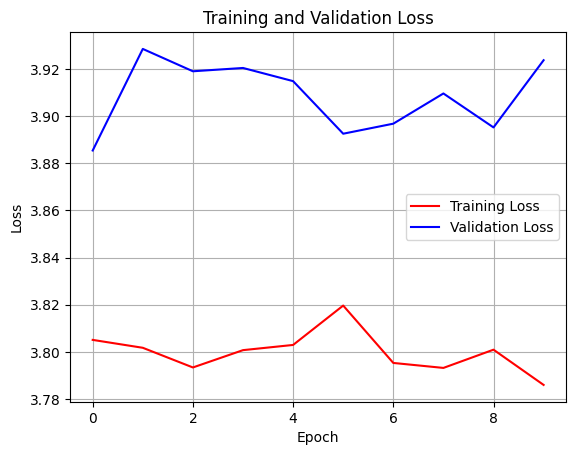

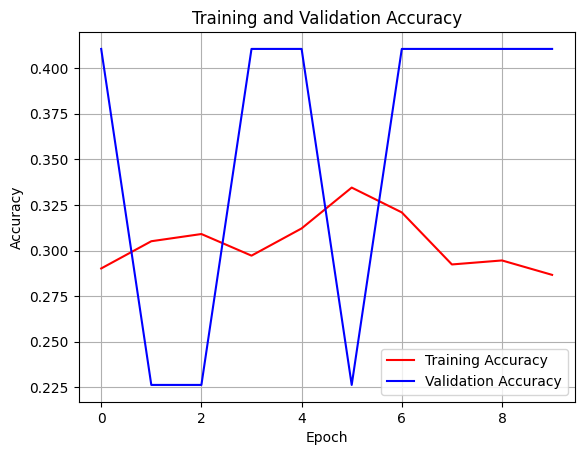

In [50]:
# Gráfico de la pérdida
plt.figure(figsize=(12,6))
# Gráfico de la 'loss'
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# Gráfico de la 'precisión'
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
#
plt.show()

#### Red Neuronal Recurrente Convolucional (CRNN) 
Esta va a ser la segunda red neuronal que vamos a probar. Estas aplican ambos tipos de redes neuronales para capturar información tanto secuencial como local.

In [32]:
max_words = 1000  # Número máximo de palabras a considerar en el tokenizer
max_sequence_length = 1000  # Longitud máxima de la secuencia (tamaño de los tweets)
embedding_dim = 100  # Dimensión de los vectores de embedding
num_classes = 11  # Número de clases (emociones)

In [45]:
y_train_one_hot = to_categorical(y_train, num_classes)
y_train_one_hot[:2], y_train_one_hot.shape

(array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       

In [57]:
# Definición del modelo CRNN
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=len(vectorizer.vocabulary_), output_dim=100, input_length=X_train.shape[0]))

# Capa Conv1D
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=4))

# Capa LSTM Bidireccional
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))

# Capa de GlobalMaxPooling1D
model.add(GlobalMaxPooling1D())

# Capa densa
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Capa de salida
model.add(Dense(11, activation='sigmoid'))  # 11 neuronas para las 11 clases de emociones

# Compilación del modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model.summary()


/Users/alejandro/Documents/Repositorios/PLN-FinalPr/.venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10


ValueError: Exception encountered when calling MaxPooling1D.call().

[1mNegative dimension size caused by subtracting 4 from 1 for '{{node sequential_9_1/max_pooling1d_5_1/MaxPool1d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 1, 4, 1], padding="VALID", strides=[1, 1, 4, 1]](sequential_9_1/max_pooling1d_5_1/MaxPool1d/ExpandDims)' with input shapes: [?,1,1,64].[0m

Arguments received by MaxPooling1D.call():
  • inputs=tf.Tensor(shape=(None, 1, 64), dtype=float32)